In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
import os

In [34]:
epochs = 50 # quantidade de vezes a ser executado o algoritmo, uma epoch é quanto todo o conjunto de treino foi utilizado
batch = 16 # número de amostras que será carregado a cada execução

In [35]:
#carrega o modelo da ResNet50V2 com os pesos aprendidos no treino da ImageNet sem a camada densa (include_top=False)

base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False)

In [36]:
#O restante do modelo e suas camadas são discutidos a seguir
#x recebe o final da inception_v3

x=base_model.output

In [37]:
#Nova configuração para o modelo


#adiciona apos x uma camada AveragePooling2D e atribui este no a x novamente (logo x e o topo novamente)
x=tf.keras.layers.GlobalAveragePooling2D()(x)

#adiciona apos x uma camada densa com 32 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(128,activation='relu')(x)

#adiciona apos x uma camada densa com 64 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(64,activation='relu')(x)

#adiciona apos x uma camada densa com 128 neuronios com funcao de ativacao relu. Atribui este no a x novamente
x=tf.keras.layers.Dense(32,activation='relu')(x)

#adiciona após x os neurônios que devem ser utilizados, nesse caso foram desligados 20% dos neuronios
x=tf.keras.layers.Dropout(0.5)(x)

#adiciona apos x uma camada densa com 7 neuronios (sete classes) com funcao de ativacao softmax (distribuicao de probabilidade). Atribui este no a preds
preds=tf.keras.layers.Dense(7,activation='softmax')(x)

#definindo modelo final
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

#mostrando modelo final e sua estrutura
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [38]:
#congelando os neuronios já treinados na ImageNet, queremos retreinar somente a ultima camada
for l in model.layers:
    if l.name.split('_')[0] != 'dense':
        l.trainable=False
    else:
        l.trainable=True

In [39]:
#iniciando objeto que apanhara todas as imagens de treino, processando as imagens com o metodo da ResNet50V2
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input) #included in our dependencies

#iniciando objeto que apanhara todas as imagens de teste, processando as imagens com o metodo da ResNet50V2
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

In [40]:
#CARREGANDO PRÓPRIO DATASET PARA USO

#definindo gerador de imagens de treino
train_generator = train_data_gen.flow_from_directory('data_tt/train',
                                                 target_size=(224, 224), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

#definindo gerador de imagens de teste
test_generator = test_data_gen.flow_from_directory('data_tt/test',
                                                 target_size=(224, 224), # tamanho da imagem para o generator                                                  
                                                 batch_size=batch,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 731 images belonging to 7 classes.
Found 186 images belonging to 7 classes.


In [41]:
lr = tf.keras.optimizers.Adam(learning_rate=0.0001)#estabelecendo taxa de otimização

model.compile(optimizer=lr, loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
#definicao dos steps
step_size_train = train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size

In [43]:
#treinando e testando o modelo
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=epochs,
                   validation_data=test_generator,
                   validation_steps=step_size_test)

c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
45/45 [==============================] - 73s 2s/step - loss: 1.9633 - accuracy: 0.2037 - val_loss: 1.7053 - val_accuracy: 0.3523
Epoch 2/50
45/45 [==============================] - 69s 2s/step - loss: 1.7113 - accuracy: 0.3120 - val_loss: 1.5332 - val_accuracy: 0.3864
Epoch 3/50
45/45 [==============================] - 69s 2s/step - loss: 1.5514 - accuracy: 0.3715 - val_loss: 1.4134 - val_accuracy: 0.4659
Epoch 4/50
45/45 [==============================] - 69s 2s/step - loss: 1.4906 - accuracy: 0.3789 - val_loss: 1.3628 - val_accuracy: 0.4602
Epoch 5/50
45/45 [==============================] - 69s 2s/step - loss: 1.4066 - accuracy: 0.4413 - val_loss: 1.2821 - val_accuracy: 0.4886
Epoch 6/50
45/45 [==============================] - 69s 2s/step - loss: 1.3309 - accuracy: 0.4878 - val_loss: 1.2182 - val_accuracy: 0.5057
Epoch 7/50
45/45 [==============================] - 69s 2s/step - loss: 1.3096 - accuracy: 0.4865 - val_loss: 1.2026 - val_accuracy: 0.4943
Epoch 8/50
45/45 [==

In [44]:
#Avaliando o modelo
loss_train, train_acc = model.evaluate_generator(train_generator, steps=step_size_train)
loss_test, test_acc = model.evaluate_generator(test_generator, steps=step_size_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train: 0.971, Test: 0.557


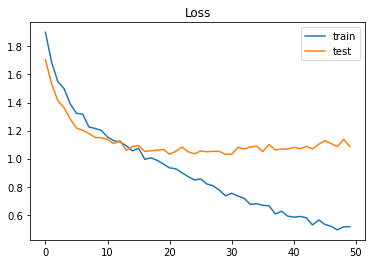

In [45]:
#Apresentando resultados em graficos
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

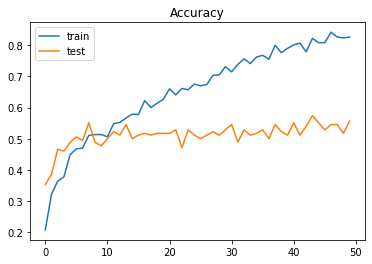

In [46]:
# Criando graficos para visualização dos resultados
print()
print()
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [47]:
print('Criando classificações..')
labels = os.listdir('Database')
print('Rótulos', labels)
#criando estruturas para métricas de avaliação, processo um pouco mais demorado
Y_pred = model.predict_generator(test_generator)
print('Preds Created')
y_pred = np.argmax(Y_pred, axis=1)
print('Preds 1D created')

Criando classificações..
Rótulos ['carcinoma_in_situ', 'light_dysplastic', 'moderate_dysplastic', 'normal_columnar', 'normal_intermediate', 'normal_superficiel', 'severe_dysplastic']


c:\users\vinicius\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Preds Created
Preds 1D created


----------------CLASSIFICATION--------------
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.16      0.17      0.16        30
   light_dysplastic       0.22      0.22      0.22        37
moderate_dysplastic       0.13      0.13      0.13        30
    normal_columnar       0.00      0.00      0.00        20
normal_intermediate       0.08      0.07      0.08        14
 normal_superficiel       0.06      0.07      0.06        15
  severe_dysplastic       0.22      0.23      0.22        40

           accuracy                           0.15       186
          macro avg       0.12      0.13      0.12       186
       weighted avg       0.15      0.15      0.15       186



<AxesSubplot:>

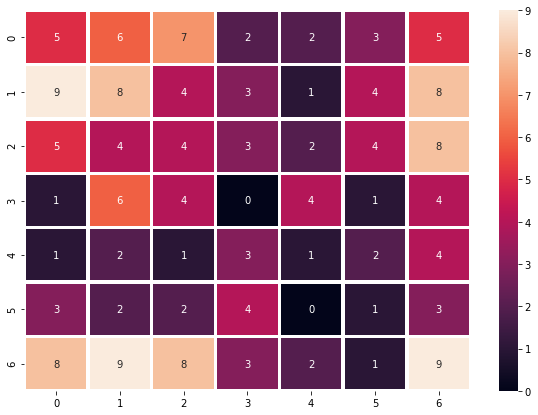

In [48]:
classification = classification_report(test_generator.classes, y_pred, target_names=labels)
print('----------------CLASSIFICATION--------------')
print(classification)
matrix = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, linewidths=2.5)